# Support vector machines

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import *
from IPython.display import display

from sklearn.svm import SVC

%matplotlib inline

In [2]:
# set the seaborn style to have a white background
sns.set(style="ticks", color_codes=True)

In [3]:
def matrix_ranges(X):
    x1_min, x2_min = np.amin(X, axis=0) - np.std(X, axis=0)/2
    x1_max, x2_max = np.amax(X, axis=0) + np.std(X, axis=0)/2
    
    x1_range = x1_max - x1_min
    x2_range = x2_max - x2_min
    
    return x1_min, x1_max, x1_range, x2_min, x2_max, x2_range

In [4]:
def run_svm(X, Y, kernel='linear', C=1.0):
    model = SVC(kernel=kernel, C=C)
    model.fit(X, Y)
    
    # code taken from:
    # http://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html
    margin = 1. / np.sqrt(np.sum(model.coef_ ** 2))
    
    return model, margin


def plot_hyperplane_margins(model, x1_min, x1_max, margin):
    
    weights = model.coef_[0]
    
    alpha = -weights[0] / weights[1]
    
    xx = np.linspace(x1_min, x1_max)
    
    # Intercept does not mean the same thing in SVM as regression
    yy = alpha * xx - (model.intercept_[0]) / weights[1]
    
    yy_down = yy + alpha * margin
    yy_up = yy - alpha * margin
    
    return xx, yy, yy_down, yy_up
    

In [5]:
def svm_plot(X, Y, point_size=85, figsize=[9,7], C=1.0):

    x1_min, x1_max, x1_r, x2_min, x2_max, x2_r = matrix_ranges(X)

    svm, margin = run_svm(X, Y, kernel='linear', C=C)

    xx, yy, yy_down, yy_up = plot_hyperplane_margins(svm, x1_min, x1_max, margin)

    # Set the figure size to be big enough to see stuff
    plt.figure(figsize=figsize)

    # plot the line, the points, and the nearest vectors to the plane
    plt.plot(xx, yy, 'k-', lw=2)
    plt.plot(xx, yy_down, 'k--')
    plt.plot(xx, yy_up, 'k--')

    plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1],
                s=point_size*4, facecolors='none', edgecolors='black',
                lw=1.5)

    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, s=point_size)

    # set the axis limits:
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    
    plt.xlabel('weight', fontsize=20)
    plt.ylabel('height', fontsize=20)
    
    plt.tick_params(labelsize=14)

    plt.show()

In [6]:
class XY():
    
    def __init__(self):
        self.f_hw = None
        self.m_hw = None
        self.scaler = None
        self.X = None
        self.Y = None
        self.cls_n = 20
        
    def update_params(self, f_hw, m_hw, scaler):
        update = False
        if self.f_hw != f_hw:
            self.f_hw = f_hw
            update = True
        if self.m_hw != m_hw:
            self.m_hw = m_hw
            update = True
        if self.scaler != scaler:
            self.scaler = scaler
            update = True
                
        if update:
            self.update_XY()
            
    def update_XY(self):
        
        randM = np.random.randn(self.cls_n, 2)*self.scaler + self.m_hw
        randF = np.random.randn(self.cls_n, 2)*self.scaler + self.f_hw
        
        self.X = np.vstack([randM, randF])
        self.Y = np.array([0]*self.cls_n + [1]*self.cls_n)

    

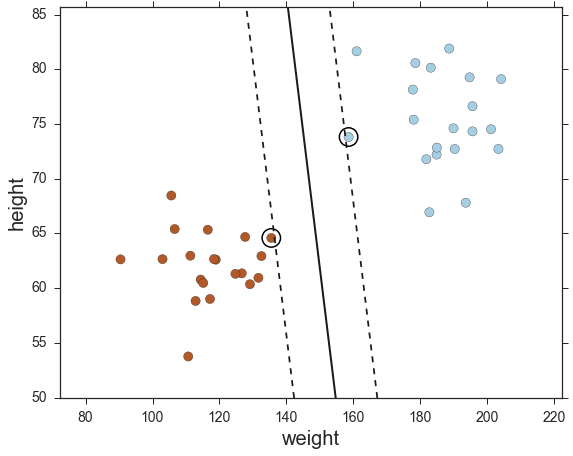

In [7]:
figsize=[9,7]

XY_container = XY()

def svm_plotter(log_C=0,
                weight_diff=50,
                height_diff=6,
                weight_std=16,
                height_std=4):
    
    f_hw = [150-(weight_diff/2.), 69-(height_diff/2.)]
    m_hw = [150+(weight_diff/2.), 69+(height_diff/2.)]
    scaler = [weight_std, height_std]
    
    XY_container.update_params(f_hw, m_hw, scaler)
    
    svm_plot(XY_container.X, XY_container.Y, C=10**log_C, figsize=figsize)
    
widgets.interact(svm_plotter, 
                 log_C=widgets.FloatSlider(min=-4.0, max=4.0, step=0.1, continuous_update=False, value=0),
                 weight_diff=widgets.IntSlider(min=0, max=100, step=5, continuous_update=False, value=50),
                 height_diff=widgets.IntSlider(min=0, max=24, step=2, continuous_update=False, value=6),
                 weight_std=widgets.IntSlider(min=1, max=20, step=1, continuous_update=False, value=16),
                 height_std=widgets.IntSlider(min=1, max=10, step=1, continuous_update=False, value=4))

---

## How does the SVM classify?

#### [NOTE] We will first get an intuition for the special _linearly separable_ classification case.

---

In the linearly separable case, support vector machines fit the **decision boundary** that is defined by the largest margin between the closest points for each class. This is commonly called the **maximum margin hyperplane (MMH)**.

![linearly separable SVM MMH](../assets/images/Margin.png)

---

## MMH function

The decision boundary (MMH) is derived by the [discriminant function](https://en.wikipedia.org/wiki/Discriminant_function_analysis#Discriminant_functions) (a linear combination of predictors that maximizes the difference between groups):

### $$ f(x) = w^T x + b $$

where **`w`** is the weight vector and **`b`** is the bias. 

Note that _`bias`_ term in the case of SVM is confusingly the equivalent of intercept in regression.

The sign of solved `f(x)` for an `x` observation determines the (binary) class label of the observation `x`.

![depiction of discriminant function](../assets/images/mmh.png)

---

## Why discriminate based on this margin?

**SVM solves for the decision boundary that minimizes generalization error.** 

Minimized generalization error is equivalent to the maximum margin. Why?

They are equivalent because using the MMH as the decision boundary **minimizes the probability that a small perturbation of an observation will produce a classification error.**

---

## How SVM finds the maximum margin

The optimization formula is below:

### $$\text{minimize: } \space \frac{1}{2}||w||^2$$ $$\text{subject to: } y_i(w^T x_i + b) \geq 1 \text{ for } i = 1,..,N$$

### _But what the hell does this mean??_


### $$\text{minimize: } \space \frac{1}{2}||w||^2$$ $$\text{subject to: } y_i(w^T x_i + b) \geq 1 \text{ for } i = 1,..,N$$

**Don't worry about the why the left hand side is 1 right now! Just know that values less than 1 mean that the point falls on the _wrong side of the margin_.**

Without getting into the math details, the second portion of the optimization is saying: 

    first, every point needs to be on the correct side of the margins on either class side.
    
The first portion of the optimization is saying:

    given the class observations fall on the correct sides of the margins, maximize the distance between the margins by modifying the weights

Because of this, **the margin depends only on the subset of the training data where the classes are closest to each other.**

These points are called the **support vectors**. The other points (further from the decision boundary) don’t affect the construction of the MMH at all.

But remember: this formulation only works if the two classes are linearly separable!

---

## SVM optimization without linear separability

The modified formula is below:

### $$ \text{minimize: } \space \frac{1}{2}||w||^2 + C \sum_{i=1}^N \xi_i $$ $$ \text{subject to: } y_i(w^T x_i + b) \geq 1 - \xi_j \text{ for } i = 1,..,N \text{ and } \xi_i > 0 $$

Now we have a "hyper-parameter" **C** which is called the "soft-margin constant". It is a "penalty" similar to the penalties in the Ridge or the Lasso. It multiples the **sum of the errors, which are the distances from the margins of the points on the wrong side of their margin.**

This allows the SVM to classify non-linearly separable problems by allowing errors to occur. **It is another example of _regularization._** Why? Because changing the C hyper-parameter changes the influence of the errors. The lower the value of C, the more that errors are allowed. This increases the bias of the model!

For those interested in exporing the math more, [there is a great tutorial here.](http://www.svm-tutorial.com/2015/06/svm-understanding-math-part-3/#more-457)

![soft margin](../assets/images/soft_margin.png)

---

## Solving non-linear boundaries with the "kernel trick"

I'm definitely not going to get into the math behind the kernel trick.

All you need to understand here is that with an SVM **you can arbitrarily transform your observations that _have no linear seperability_ by putting them into a different "dimensional space".**

Yes, confusing I know. The following pictures should give you at least a general intuition of what happens.

![kernel transform viz](../assets/images/kernel_viz.png)

![polynomial kernel](../assets/images/nonlinear-1.png)

![gaussian kernel](../assets/images/nonlinear-2.png)